In [49]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader as data_reader
import datetime
import ta
from sklearn import preprocessing, linear_model, metrics, neighbors, feature_selection, ensemble, multioutput
from statsmodels import regression

In [152]:
appl = data_reader.get_data_yahoo('AAPL', start=datetime.datetime(2001, 1, 1), end=datetime.datetime(2019, 8, 9))
spy = data_reader.get_data_yahoo('SPY', start=datetime.datetime(2001, 1, 1), end=datetime.datetime(2019, 8, 9))
appl.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2001-01-02,1.089286,1.040179,1.062500,1.062500,113078000.0,0.924482
2001-01-03,1.191964,1.031250,1.035714,1.169643,204268400.0,1.017707
2001-01-04,1.321429,1.200893,1.295759,1.218750,184849000.0,1.060436
2001-01-05,1.241071,1.147321,1.209821,1.169643,103089000.0,1.017707
2001-01-08,1.213170,1.138393,1.209821,1.183036,93424800.0,1.029361


In [153]:
appl.describe()

,High,Low,Open,Close,Volume,Adj Close
count,4680.000000,4680.000000,4680.000000,4680.000000,4.680000e+03,4680.000000
mean,59.227883,58.098642,58.676359,58.677083,1.165798e+08,54.727269
std,60.710405,59.693577,60.194961,60.212747,9.681993e+07,58.504425
min,0.942143,0.908571,0.927857,0.937143,9.835000e+06,0.815409
25%,6.736786,6.598214,6.663571,6.643214,4.818730e+07,5.780266
50%,35.111429,34.330713,34.683571,34.713572,8.871345e+07,30.204314
75%,99.892502,98.042501,98.682501,98.782499,1.540704e+08,91.709465
max,233.470001,229.779999,230.779999,232.070007,8.432424e+08,227.839798


In [154]:
appl.dropna(inplace=True)
spy.dropna(inplace=True)

In [155]:
return_appl = appl['Adj Close'].pct_change()[1:]
return_spy = spy['Adj Close'].pct_change()[1:]

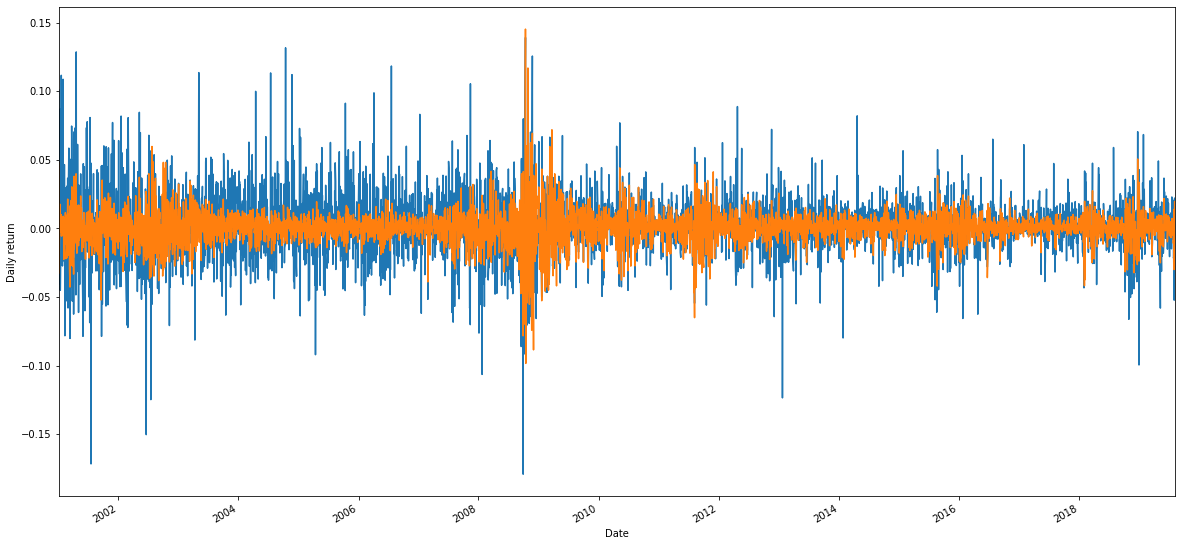

In [156]:
plt.figure(figsize=(20,10))
return_appl.plot()
return_spy.plot()
plt.ylabel("Daily return") 
plt.show()

In [157]:
def calculate_alpha_and_beta(x, y, periods):
    x_values = x['Adj Close'].pct_change()[1:].values
    y_values = y['Adj Close'].pct_change()[1:].values
    
    betas = [None for index in range(periods + 1)]
    alphas = [None for index in range(periods + 1)]
    
    for index in range(len(x_values) - periods):
        X = x_values[index: (index + periods)]
        Y = y_values[index: (index + periods)]

        X = sm.add_constant(X)
        model = regression.linear_model.OLS(Y, X).fit()
        
        alphas.append(model.params[0])
        betas.append(model.params[1])

    y['alpha'] = np.array(alphas) 
    y['beta'] = np.array(betas) 
        
    return y.copy()

In [159]:
appl = calculate_alpha_and_beta(spy, appl, 64)
print(appl)

                  High         Low        Open       Close       Volume  \
Date                                                                      
2001-01-02    1.089286    1.040179    1.062500    1.062500  113078000.0   
2001-01-03    1.191964    1.031250    1.035714    1.169643  204268400.0   
2001-01-04    1.321429    1.200893    1.295759    1.218750  184849000.0   
2001-01-05    1.241071    1.147321    1.209821    1.169643  103089000.0   
2001-01-08    1.213170    1.138393    1.209821    1.183036   93424800.0   
...                ...         ...         ...         ...          ...   
2019-08-05  198.649994  192.580002  197.990005  193.339996   52393000.0   
2019-08-06  198.070007  194.039993  196.309998  197.000000   35824800.0   
2019-08-07  199.559998  193.820007  195.410004  199.039993   33364400.0   
2019-08-08  203.529999  199.389999  200.199997  203.429993   27009500.0   
2019-08-09  202.759995  199.289993  201.300003  200.990005   24619700.0   

             Adj Close  

In [127]:
def get_technical_indicators(dataset):
        # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Adj Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Adj Close'].rolling(window=21).mean()

    # Create MACD
    dataset['26ema'] = dataset['Adj Close'].ewm(span=26, adjust=False).mean()
    dataset['12ema'] = dataset['Adj Close'].ewm(span=12, adjust=False).mean()
    dataset['MACD'] = (dataset['12ema'] - dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Adj Close'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['Adj Close'].ewm(com=0.5).mean()

    return dataset

In [162]:
appl = get_technical_indicators(appl)
appl.dropna(inplace=True)
appl.describe()


,High,Low,Open,Close,Volume,Adj Close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema
count,4595.000000,4595.000000,4595.000000,4595.000000,4.595000e+03,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000,4595.000000
mean,60.295475,59.147166,59.734721,59.735332,1.163539e+08,55.715984,55.587164,55.278138,55.171948,55.476576,0.304628,1.586339,58.450816,52.105460,55.694351
std,60.755089,59.738661,60.239425,60.257636,9.731766e+07,58.585509,58.470934,58.183488,58.049401,58.352093,1.595777,1.875774,61.263583,55.186577,58.563349
min,0.942143,0.908571,0.927857,0.937143,9.835000e+06,0.815409,0.827306,0.860453,0.863244,0.843522,-10.698082,0.015558,0.924447,0.671332,0.817557
25%,8.442142,8.174286,8.247143,8.247857,4.746420e+07,7.176468,7.199375,7.126304,7.192038,7.226647,-0.061789,0.267091,7.702910,6.272905,7.196293
50%,36.967144,35.785713,36.520000,36.320000,8.813630e+07,31.602060,31.575963,31.636812,31.401687,31.652666,0.102508,0.980903,33.334000,29.455003,31.622494
75%,100.685001,98.689999,99.579998,99.865002,1.540763e+08,92.409023,92.292718,92.057907,92.329382,92.209304,0.725389,2.188353,95.941598,87.572625,92.510253
max,233.470001,229.779999,230.779999,232.070007,8.432424e+08,227.839798,223.224060,219.401228,218.637046,221.371325,7.084879,15.069447,228.119122,211.761917,226.624626


In [163]:
print(appl.columns)

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'alpha', 'beta',
       'ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band',
       'lower_band', 'ema'],
      dtype='object')


In [164]:
appl['close'] = appl['Adj Close']
appl = appl.drop(['Adj Close', 'Close', 'Volume'], axis=1)

In [166]:
appl['alpha'].describe()

count     4595.000000
unique    4595.000000
top          0.000771
freq         1.000000
Name: alpha, dtype: float64

In [167]:
appl['beta'].describe()

count     4595.000000
unique    4595.000000
top          1.050425
freq         1.000000
Name: beta, dtype: float64

In [168]:
print(appl.columns)

Index(['High', 'Low', 'Open', 'alpha', 'beta', 'ma7', 'ma21', '26ema', '12ema',
       'MACD', '20sd', 'upper_band', 'lower_band', 'ema', 'close'],
      dtype='object')


In [169]:
def split_data(data):
        total_length = len(data)
        train_index = round(0.8 * total_length)
        
        train = data[:int(train_index), :]
        test = data[int(train_index):, :]
        
        return train, test

In [170]:
train, test = split_data(appl.values)

In [171]:
def normalize_data(train, test):
        normalizer = preprocessing.Normalizer()
        train = normalizer.fit_transform(train)
        test = normalizer.transform(test)        
        return train, test

In [172]:
train, test = normalize_data(train, test)

In [173]:
print("Train data shape: ", train.shape)
print("Test data shape: ", test.shape)

Train data shape:  (3676, 15)
Test data shape:  (919, 15)


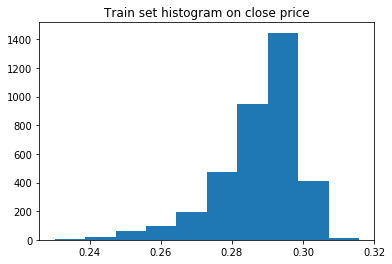

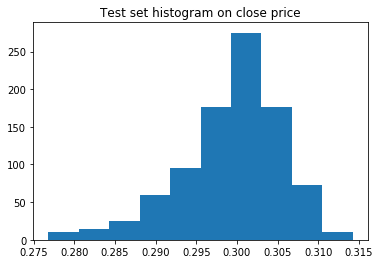

In [174]:
plt.hist(train[:,-1])
plt.title("Train set histogram on close price") 
plt.show()

plt.hist(test[:,-1])
plt.title("Test set histogram on close price") 
plt.show()

In [175]:
def formate_data(data, x_len, y_len):
        x_s = []
        y_s = []
        
        for index in range(len(data) - (x_len + y_len)):
            # We delete the close price from the xs
            x_s.append(data[index: (index + x_len), :-1])
            # We just want the close price as target variable
            y_s.append(data[(index + x_len):(index + x_len + y_len), -1])
        
        x_s = np.array(x_s)
        y_s = np.array(y_s)
        
        return x_s, y_s

In [176]:
x_train, y_train = formate_data(train, 24, 7)
x_test, y_test = formate_data(test, 24, 7)

print("X train shape:", x_train.shape)
print("Y train shape:", y_train.shape)

print("X test shape:", x_test.shape)
print("Y test shape:", y_test.shape)

X train shape: (3645, 24, 14)
Y train shape: (3645, 7)
X test shape: (888, 24, 14)
Y test shape: (888, 7)


In [178]:
X = np.reshape(x_train, (3645, 24 * 14))
y = y_train
reg = linear_model.LinearRegression().fit(X, y)
print(reg.score(X, y))

0.7315754346781496


/anaconda3/envs/sp500/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [180]:
Xt = np.reshape(x_test, (888, 24 * 14))
yt = y_test
pred = reg.predict(Xt)
print("yt shape: ", yt.shape)
print("pred shape: ", pred.shape)

yt shape:  (888, 7)
pred shape:  (888, 7)


In [181]:
mse = metrics.mean_squared_error(yt, pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  2.2002922914921915e-05


In [182]:
def plot_results_against_true_data(tested_data, true_data, title="Results comparison"):
        plt.figure(figsize = (15,6))
        # style
        plt.style.use('seaborn-darkgrid')

        plt.plot(
            range(len(tested_data)), 
            tested_data, 
            marker='', 
            color="blue", 
            linewidth=0.5, 
            alpha=1, 
            label="Predicted Data"
        )

        plt.plot(
            range(len(true_data)), 
            true_data, 
            marker='', 
            color="black", 
            linewidth=0.5, 
            alpha=0.8, 
            label="Real Data"
        )

        plt.legend(loc=2, ncol=2)
        plt.title(title, loc='left', fontsize=12, fontweight=0, color='orange')
        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.show()

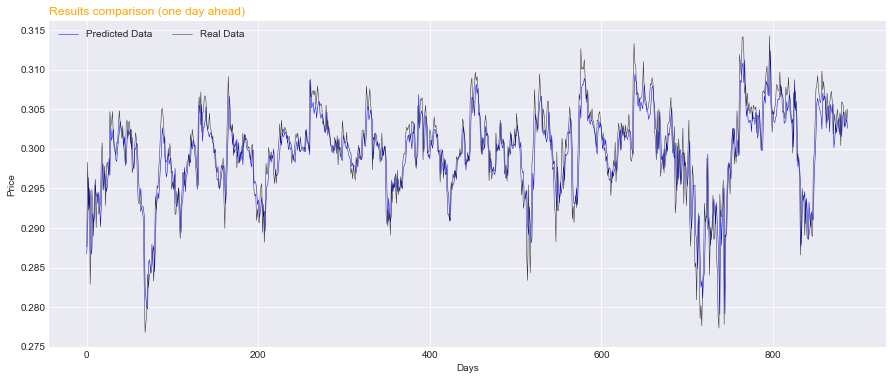

In [183]:
plot_results_against_true_data(pred[:,0], yt[:,0], title="Results comparison (one day ahead)")

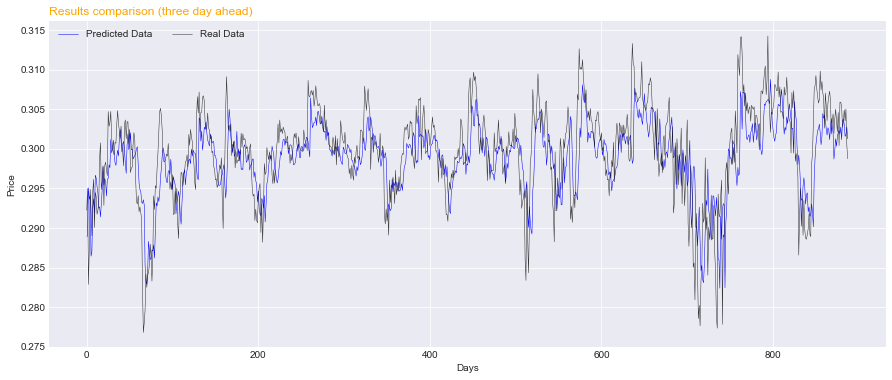

In [184]:
plot_results_against_true_data(pred[:,2], yt[:,2], title="Results comparison (three day ahead)")

In [185]:
print(pred[:,0].max())

0.31235423938113005


In [193]:
reg = ensemble.GradientBoostingRegressor(n_estimators=300)
reg = multioutput.MultiOutputRegressor(reg, n_jobs=-1).fit(X, y)
print(reg.score(X, y))

0.9136570646941041


In [194]:
Xt = np.reshape(x_test, (888, 24 * 14))
yt = y_test
pred = reg.predict(Xt)
print("yt shape: ", yt.shape)
print("pred shape: ", pred.shape)

yt shape:  (888, 7)
pred shape:  (888, 7)


In [195]:
mse = metrics.mean_squared_error(yt, pred)
print("Score: ", reg.score(Xt, pred))
print("Mean Squared Error: ", mse)

Score:  1.0
Mean Squared Error:  5.140235085132818e-05


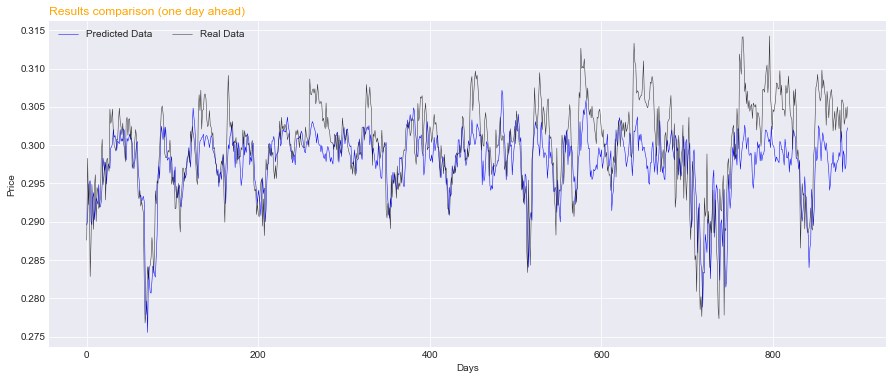

In [196]:
plot_results_against_true_data(pred[:,0], yt[:,0], title="Results comparison (one day ahead)")

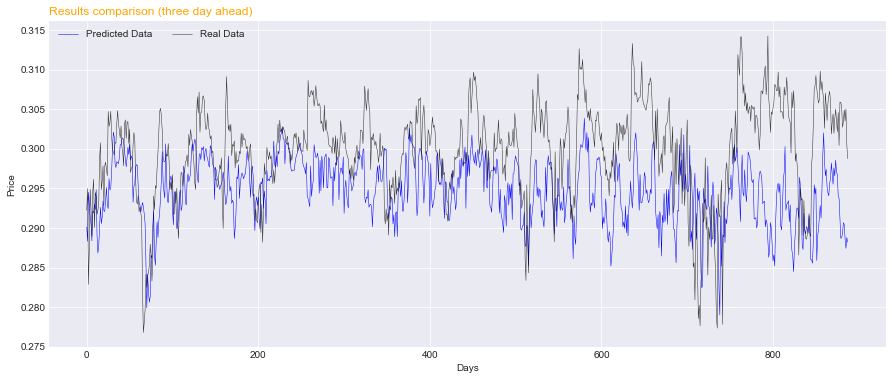

In [197]:
plot_results_against_true_data(pred[:,2], yt[:,2], title="Results comparison (three day ahead)")